# Naive Bayes Network notebook

#### Import dependencies

In [1]:
# Import dependencies
#%pip install pgmpy
#%pip install tabulate
#%pip install pandas
#%pip install networkx
#%pip install matplotlib

#### Load libraries

In [2]:
# Load libraries
import pgmpy as pg
import tabulate as tb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Data import and cleaning

#### Import BigPerf data

In [3]:
# Import data
df = pd.read_csv("C:\\Users\\Keir McGlinn-Shaw\\Documents\\Stage-3\\Dissertation\\Data\\Use\\BigPerfMetrics.csv")

df.head()

,Block_ID,HDFS_BW,HDFSTranmissionTime,Mapper_ID,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_ID,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_ID.1,Block_BW,BlockTransmissionTime,TransactionTime
0,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer0,341739,480,3.80,250.14,reducer0_Block_1,0.0,0.00,1578.79
1,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer1,150000,120,50.00,18.99,reducer1_Block_1,50.0,20.00,1007.64
2,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer2,382530,480,4.48,212.22,reducer2_Block_1,3.7,270.02,1811.61
3,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer3,150000,120,5.88,161.57,reducer3_Block_1,3.7,270.02,1400.96
4,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,18.41,4.16,reducer4,457419,480,5.88,161.53,reducer4_Block_1,3.7,270.02,1761.83


#### Clean data of unwanted variables and missing values

In [4]:
# Clean data
df.dropna()

df.drop(labels=['Block_ID', 'Mapper_ID', 'Reducer_ID', 'Block_ID.1'], axis=1, inplace=True)

df.head()

,HDFS_BW,HDFSTranmissionTime,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_BW,BlockTransmissionTime,TransactionTime
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83


#### Rename columns to better fit in drawn charts and for ease of use

In [5]:
# Rename column headers to abbreviations

nodes = ['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT', 'TT']

df.columns = nodes

df.head(10)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83
5,11.81,80.63,652289,765.49,18.41,4.16,150000,120,6.98,136.24,3.7,270.02,1376.54
6,11.81,80.63,652289,765.49,18.41,4.16,563904,480,3.80,250.14,3.7,270.02,1850.44
7,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63
8,11.81,80.63,652289,765.49,18.41,4.16,430890,480,3.80,250.14,3.7,270.02,1850.44
9,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63


#### Define funtion to discretise data into three catagories

In [6]:
'''
Splits data into three bins of equal size using: https://pandas.pydata.org/docs/reference/api/pandas.cut.html
'''
def split_tertiles(df):
    tertile_labels = ['0.Low', '1.Medium', '2.High']

    tert_df = pd.DataFrame()

    for column_name in df:
        tert_df[column_name], bins = pd.cut(df[column_name], 3, labels=tertile_labels, ordered=True,retbins=True)

        # print(column_name)
        # print(bins[0])
        # print(bins[1])
        # print(bins[2])
        # print(bins[3])

        tert_df[column_name] = tert_df[column_name].cat.rename_categories([f'Low ({str(round(bins[0]))} to {str(round(bins[1]))}]', f'Medium ({str(round(bins[1]))} to {str(round(bins[2]))}]', f'High ({str(round(bins[2]))} to {str(round(bins[3]))}]'])

    # Change type of values stored in dataframe to avoid errors arrising from using the Category type when the dataframe is fed into the pgmpy.metrics.metrics correlation_score function
    tert_df = tert_df.astype('object')

    return tert_df

#### Descritise data into catagories

In [7]:
# Discretise BigPerf dataset
cat_df = split_tertiles(df)

cat_df.head()

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,High (8 to 12],Low (0 to 118],Low (651992 to 751378],Low (765 to 1003],High (20 to 30],Low (2 to 18],Medium (287968 to 425936],High (360 to 480],Low (4 to 53],High (169 to 250],Low (0 to 17],Low (0 to 90],Low (1006 to 1626]
1,High (8 to 12],Low (0 to 118],Low (651992 to 751378],Low (765 to 1003],High (20 to 30],Low (2 to 18],Low (149586 to 287968],Low (120 to 240],Low (4 to 53],Low (6 to 88],High (33 to 50],Low (0 to 90],Low (1006 to 1626]
2,High (8 to 12],Low (0 to 118],Low (651992 to 751378],Low (765 to 1003],Medium (11 to 20],Low (2 to 18],Medium (287968 to 425936],High (360 to 480],Low (4 to 53],High (169 to 250],Low (0 to 17],High (180 to 270],Medium (1626 to 2245]
3,High (8 to 12],Low (0 to 118],Low (651992 to 751378],Low (765 to 1003],Medium (11 to 20],Low (2 to 18],Low (149586 to 287968],Low (120 to 240],Low (4 to 53],Medium (88 to 169],Low (0 to 17],High (180 to 270],Low (1006 to 1626]
4,High (8 to 12],Low (0 to 118],Low (651992 to 751378],Low (765 to 1003],Medium (11 to 20],Low (2 to 18],High (425936 to 563904],High (360 to 480],Low (4 to 53],Medium (88 to 169],Low (0 to 17],High (180 to 270],Medium (1626 to 2245]


In [8]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(cat_df, test_size=0.2, random_state=20)

In [9]:
from itertools import combinations

import networkx as nx
from sklearn.metrics import f1_score
from pgmpy.models import BayesianModel, NaiveBayes, BayesianNetwork
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator

In [10]:
model = NaiveBayes(feature_vars=['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT'], dependent_var='TT')

In [11]:
model.fit(data=training_data, parent_node='TT', estimator=MaximumLikelihoodEstimator )
bayes_model = BayesianNetwork(model)

bayes_model.fit(data=training_data,
    estimator=MaximumLikelihoodEstimator,
    complete_samples_only=False)

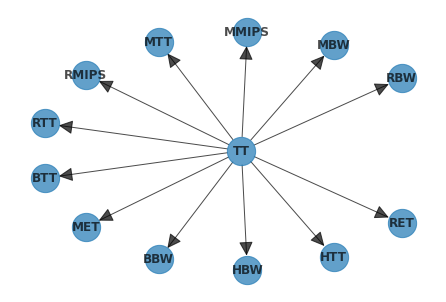

In [12]:
G = nx.DiGraph()
G.add_edges_from(bayes_model.edges)
G.add_nodes_from(bayes_model.nodes)
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, with_labels=True, arrowsize=30, node_size=800, alpha=0.7, font_weight="bold")  # Draw the original graph

In [13]:
bayes_model.get_cpds()

[<TabularCPD representing P(TT:3) at 0x259d8327970>,
 <TabularCPD representing P(RBW:2 | TT:3) at 0x259d82d3af0>,
 <TabularCPD representing P(MBW:3 | TT:3) at 0x259d8304d60>,
 <TabularCPD representing P(MMIPS:3 | TT:3) at 0x259d8307370>,
 <TabularCPD representing P(MTT:3 | TT:3) at 0x259d8326ad0>,
 <TabularCPD representing P(RMIPS:3 | TT:3) at 0x259d8356350>,
 <TabularCPD representing P(RTT:3 | TT:3) at 0x259d83260b0>,
 <TabularCPD representing P(BTT:2 | TT:3) at 0x259d82d3940>,
 <TabularCPD representing P(MET:3 | TT:3) at 0x259d82d2e60>,
 <TabularCPD representing P(BBW:2 | TT:3) at 0x259d8327a60>,
 <TabularCPD representing P(HBW:2 | TT:3) at 0x259d8354a60>,
 <TabularCPD representing P(HTT:2 | TT:3) at 0x259d8325fc0>,
 <TabularCPD representing P(RET:2 | TT:3) at 0x259d8327a00>]

In [14]:
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

f1 = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=f1_score, return_summary=False)
acc = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=accuracy_score, return_summary=False)
pr = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=precision_score, return_summary=False)
recall = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=recall_score, return_summary=False)
ls = log_likelihood_score(model=bayes_model, data=testing_data)
ss = structure_score(model=bayes_model, data=testing_data, scoring_method='bdeu')


print(f'F1 score: {f1}')
print(f'Accuracy score: {acc}')
print(f'Precision score: {pr}')
print(f'Recall score: {recall}')
print(f'Log-likilihood score: {ls}')
print(f'Strcture score: {ss}')

F1 score: 0.0
Accuracy score: 0.6153846153846154
Precision score: 0.0
Recall score: 0.0
Log-likilihood score: -4584.586127920558
Strcture score: -4704.319040095721


C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
def store_metrics(metrics_file_name, model_name, f1, accuracy, precision, recall, log_likelihood_score, structure_score):
    try: 
        df = pd.read_csv('Model-metrics.csv', header=0, index_col=False)
    except:
        df_columns = ['Model', 'F1', 'Accuracy', 'Precision', 'Recall', 'Log likelihood score', 'Structure score']

        df = pd.DataFrame(columns=df_columns)

    else:
        df = df[df.Model != model_name]
        
    new_row = {'Model': model_name, 'F1': f1, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'Log likelihood score': log_likelihood_score, 'Structure score': structure_score}

    df = df.append(new_row, ignore_index=True)

    # Write to file
    df.to_csv(metrics_file_name, index=False)


In [16]:
model_name = 'Naive Bayes'
metrics_file_name = 'Model-metrics.csv'

store_metrics(metrics_file_name=metrics_file_name, model_name=model_name, f1=f1, accuracy=acc, precision=pr, recall=recall, log_likelihood_score=ls, structure_score=ss)

C:\Users\KEIRMC~1\AppData\Local\Temp/ipykernel_21608/3521155595.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


In [17]:
print(f'Check model: {bayes_model.check_model()}\n')
for cpd in bayes_model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

Check model: True

CPT of TT:
+---------------------------+----------+
| TT(High (2245 to 2864])   | 0.281004 |
+---------------------------+----------+
| TT(Low (1006 to 1626])    | 0.165354 |
+---------------------------+----------+
| TT(Medium (1626 to 2245]) | 0.553642 |
+---------------------------+----------+ 

CPT of RBW:
+------------------------+-----+---------------------------+
| TT                     | ... | TT(Medium (1626 to 2245]) |
+------------------------+-----+---------------------------+
| RBW(High (101 to 150]) | ... | 0.24266666666666667       |
+------------------------+-----+---------------------------+
| RBW(Low (4 to 53])     | ... | 0.7573333333333333        |
+------------------------+-----+---------------------------+ 

CPT of MBW:
+------------------------+-----+---------------------------+
| TT                     | ... | TT(Medium (1626 to 2245]) |
+------------------------+-----+---------------------------+
| MBW(High (20 to 30])   | ... | 0.1066666666